# drosophila_simulation_tollRM9

> copy of notebook `04_drosophila_simulation`, simulate embryo with no passive cells

In [ ]:
import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln
import CE_simulation.isogonal as iso
import CE_simulation.drosophila as drs

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection

from scipy import optimize, ndimage

from tqdm.notebook import tqdm

from copy import deepcopy
import pickle

In [ ]:
from typing import Union, Dict, List, Tuple, Iterable, Callable, Any
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.tree_util import Partial

from jax.config import config
config.update("jax_enable_x64", True) # 32 bit leads the optimizer to complain about precision loss
config.update("jax_debug_nans", False) # useful for debugging, but makes code slower!

In [ ]:
import ipywidgets as widgets
import functools
from matplotlib import animation, rc

In [ ]:
#| notest

import importlib

In [ ]:
## reloading the modules in case you edit them

importlib.reload(msh); importlib.reload(tns); importlib.reload(dln); importlib.reload(iso)

<module 'CE_simulation.isogonal' from '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/GBE simulation/disordered simulation/CE_simulation/CE_simulation/isogonal.py'>

## Simulation with boundary conditions and passive & active cells

### Plot initial condition

In [ ]:
# create initial condition

mesh_initial, property_dict = drs.create_rect_initial(16, 20, noise=0.1, initial_strain=0.1,
                                                      orientation='orthogonal', isogonal=0,
                                                      boundaries=['top', 'bottom',], #'left', 'right'
                                                      w_passive=0, w_passive_lr=0, random_seed=3)

In [ ]:
# set colors for edges and cells

edge_colors = {key: "tab:grey" for key in property_dict['passive_edges']}
cell_alpha = .5


cell_colors_active = {key: mpl.colors.to_rgba('tab:blue') * np.array([1,1,1,.5])
                      for key in mesh_initial.vertices.keys()
                      if not key in property_dict['passive_cells']}

(-6.5, 6.5, -9.5, 9.5)

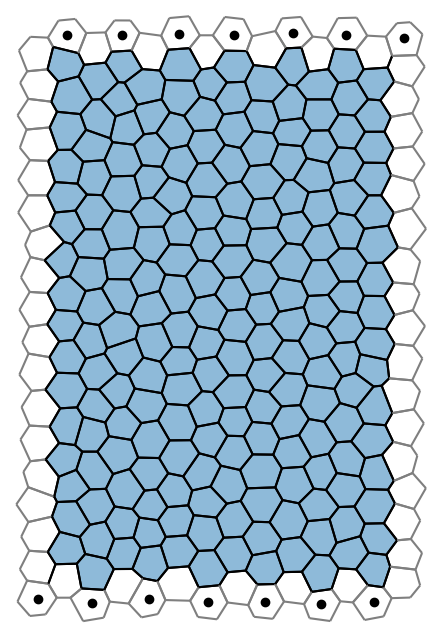

In [ ]:
fig = plt.figure(figsize=(8,8))

mesh_initial.cellplot(edge_colors=edge_colors,
                      cell_colors=cell_colors_active)
#mesh_initial.triplot(): 
#mesh_initial.labelplot()

# add line to visualize the slip boundary
bdry_x, bdry_y = (property_dict['bdry_x'], property_dict['bdry_y'])
if mesh_initial.bdry_list:
    #plt.hlines((bdry_y-.25, -bdry_y+.25), (-9, -9), (9, 9), color="k")
    for key in mesh_initial.bdry_list[0][1]+mesh_initial.bdry_list[1][1]:
        plt.scatter(*mesh_initial.vertices[key].get_centroid(), c="k")

plt.gca().set_aspect("equal", adjustable="box");
plt.xticks([],[])
plt.yticks([],[])
plt.xlim([-bdry_x-.5, bdry_x+.5])
plt.ylim([-bdry_y-.5, bdry_y+.5])

plt.axis("off")

#plt.savefig("plots/initial_cond.pdf")

## set simulation parameters

In [ ]:
## feedback parameters

m = 4
k = .5
k_cutoff = .1 # regularization term to cut off excitable feedbacl
 
passive_ids = property_dict['passive_faces']
def params_pattern(fid):
    if fid in passive_ids:
        return {"k": k, "m": 1} # tension relaxation rate in passive region
    return {"k": k, "m": 4, "k_cutoff": k_cutoff}

params_no_pattern = {"k": k, "m": m, "k_cutoff": k_cutoff}
    
dt = .005 # time step
n_steps = 50 # just a short simulation for testing purposes
forbid_reflip = 20 # numerical constant - forbid a re-flip on an edge that just collapsed for some time steps
                   # (because the edge is still very short, albeit extending, it would be detected as intercalating)
                   # More systematic treatment would check if a short junction is extending/contracting to determine
                   # whether it needs to be flipped.

minimal_l = .075 # minimal edge length, lower edge lengths trigger T1

tri_mod_area = .01 # triangle area regularization

In [ ]:
## cell shape parameters

tol, maxiter = (1e-4, 100000)  #1e-4
mod_bulk = 1
mod_shear = 0 #.25 # .5
angle_penalty = 1000
bdry_penalty = 5000

epsilon_l = (1e-3, 1e-4)  # mollifying parameters to ensure energy differentiability

A0 = jnp.sqrt(3)/2
mod_area = 0
P0 = 2*jnp.sqrt(3)/2
mod_perimeter = 0

bdr_weight = 4 # 2

passive_cells = property_dict['passive_cells']
rel_elastic_modulus = .8 # reduction in elastic modulus in passive cells
cell_id_to_modulus = np.vectorize(lambda x: 1-rel_elastic_modulus*(x in passive_cells))

use_voronoi = False # don't do shape optimization, run voronoi instead

In [ ]:
# package all into a single dict to pass to the optimizer method

energy_args = {"mod_bulk": mod_bulk, "mod_shear": mod_shear,
               "angle_penalty": angle_penalty, "bdry_penalty": bdry_penalty, "epsilon_l": epsilon_l,
               "A0": A0, "mod_area": mod_area, "P0": P0, "mod_perimeter": mod_perimeter}
optimizer_args = {'energy_args': energy_args, 'cell_id_to_modulus': cell_id_to_modulus,
                  'tol': tol, 'maxiter': maxiter, 'verbose': True, 'bdr_weight': bdr_weight}

In [ ]:
## rest length relaxation

k_rest = 1

def rhs_rest_shape(v):
    """Rest shape relaxation but do not relax area, i.e. trace. Also, only relax passive cells"""
    if v._vid in property_dict['passive_cells']:
        delta = v.rest_shape-v.get_shape_tensor()
        return -k_rest*(delta - np.trace(delta)/2 * np.eye(2))
    else:
        return 0
    ## other option: just relax to isotropic
    #delta = v.rest_shape-v.get_shape_tensor()
    #return -k_rest*(delta - np.trace(delta)/2 * np.eye(2))


## Simulation loop

Note: when saving, we need to save some additional data (the passive tensions and the cell rest shapes) which are not by default saved by the `HalfEdgeMesh` save routine. They are saved as dicts, so that after loading the properties can be set again, for example to continue simulating.

Few if any JIT-recompilations during simulation run according to `get_E._cache_size(), get_E_jac._cache_size()`

In [ ]:
meshes = [deepcopy(mesh_initial)]
times = [0]
last_flipped_edges = [[]] # T1_count = np.cumsum([len(x) for x in last_flipped_edge])

In [ ]:
save = True
save_dir = "runs/toll_rm9_test"
if save:
    try:
        os.mkdir(save_dir)
    except FileExistsError:
        print('Warning: directory exists')
save_self(save_dir, fname="04d_drosophila_simulation_tollRM9.ipynb")

In [ ]:
## simulation loop

mesh = deepcopy(meshes[-1])
for i in tqdm(range(len(meshes)-1, n_steps)):
    # euler step
    mesh.euler_step(dt=dt, rhs_tension=tns.excitable_dt_act_pass, params=params_pattern,
                    rhs_rest_shape=rhs_rest_shape)
    # flatten triangulation
    mesh.flatten_triangulation(mod_area=tri_mod_area, tol=1e-4)
    # primal optimization
    if use_voronoi:
        mesh.set_voronoi()
    else:
        mesh.optimize_cell_shape(**optimizer_args)
    # check for intercalation
    flipped, failed_flip = mesh.intercalate(exclude=list(msh.flatten(last_flipped_edges[-forbid_reflip:])),
                                            minimal_l=minimal_l, reoptimize=False, optimizer_args=optimizer_args)
    if failed_flip:
        print(f"tpt {i}: flip {flipped}, failed {failed_flip}")
    if flipped and not failed_flip:
        print(f"tpt {i}: flip {flipped}")
    # rescale & reorient triangulation
    mesh.transform_vertices(dln.get_conformal_transform(meshes[-1], mesh))
    # log & save
    last_flipped_edges.append(flipped)
    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)
    if save:
        mesh.save_mesh(f"{save_dir}/{str(i).zfill(4)}_mesh", save_attribs=True)
last_flipped_edges.append([])

  0%|          | 0/50 [00:00<?, ?it/s]

tpt 0: flip [3390, 3628, 1746]
tpt 2: flip [2277]
tpt 3: flip [255, 2283, 114]
tpt 4: flip [1572, 630, 3867, 2448, 48]
tpt 5: flip [3942, 268, 3039, 4558]
tpt 6: flip [90]
tpt 8: flip [3426]
tpt 9: flip [3028, 1902, 625]
tpt 10: flip [1987, 2883]
tpt 11: flip [1522]
tpt 12: flip [217, 3618]
tpt 13: flip [436, 2868, 3408]
tpt 14: flip [1176, 1068, 1417]
tpt 15: flip [2578, 1942, 4060, 3642]
tpt 16: flip [490, 3411, 3256]
tpt 17: flip [3708, 4824, 636]
tpt 18: flip [238, 4431, 4171, 997]
tpt 19: flip [1335, 2545]
tpt 20: flip [2388, 2410, 3906, 540, 1251, 318, 496]
tpt 21: flip [3667, 2008, 4206, 1725, 2079]
tpt 22: flip [2164, 54, 990, 2709, 244, 442, 1075]
tpt 23: flip [1224, 1311, 307, 1269, 1291, 1872]
tpt 24: flip [2688, 604, 73, 3417, 355, 757, 3430, 2076]
tpt 25: flip [1954, 3066, 3073, 1321, 301]
tpt 26: flip [4558, 1245, 1077, 4212, 3162, 3108]
tpt 27: flip [3459, 466, 445, 1437, 388]


In [ ]:
# just for convenience, save ids of T1s at each time. The T1s at each timepoint can also be reconstructed
# from the meshes if necessary.

last_flipped_edges.append([]) 
if save:
    with open(f'{save_dir}/last_flipped_edges.pickle', 'wb') as handle:
        pickle.dump(last_flipped_edges, handle, protocol=pickle.HIGHEST_PROTOCOL)    

In [ ]:
meshes[-1].is_consistent()

True

### Loading a saved simulation

In [ ]:
## reload a mesh. need to load rest shapes and passive tensions from separate pickle files
# only load a subsample of meshes, which is helpful when dealing with large meshes which can overwhelm memory

save_dir = 'runs/germ_band_test'
meshes = [iso.CellHalfEdgeMesh.load_mesh(f'{save_dir}/{str(i).zfill(4)}_mesh', ) for i in tqdm(range(0, 99, 2))]

  0%|          | 0/50 [00:00<?, ?it/s]

# Analysis

Shows several types of plots

### Slider plots

Most importantly, visualize the mesh interactively

<IPython.core.display.Javascript object>


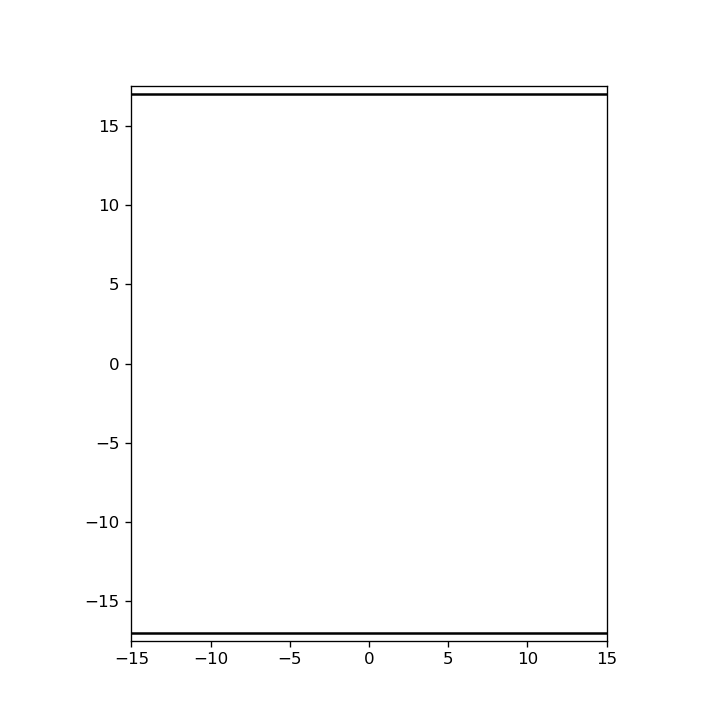

interactive(children=(IntSlider(value=24, description='i', max=49), FloatSlider(value=15.0, description='xlim'…

In [ ]:
#| notest

%matplotlib notebook

fig = plt.figure(figsize=(6, 6))
    
# fix the arguments which you do not need to tune with widgets.fixed

widgets.interact(drs.plot_mesh, i=(0, len(meshes)-1, 1), xlim=(bdry_x, 2*bdry_x),
                 ylim=widgets.fixed(bdry_y+.5), slipwall_y=widgets.fixed(bdry_y),
                 edge_colors=widgets.fixed(edge_colors), cell_colors=widgets.fixed(cell_colors_active),
                 mesh_series=widgets.fixed(meshes),
                 #flipped_series=widgets.fixed(None),
                 flipped_series=widgets.fixed(last_flipped_edges)
                );


In [ ]:
%matplotlib inline

### Rendering movies of triangulation and cells

In [ ]:
# cells

def plot_cells(i):
    plot_mesh(i, xlim=22,
    ylim=bdry_y+1, slipwall_y=None,
    edge_colors=edge_colors, cell_colors=cell_colors_active,
    mesh_series=meshes, flipped_series=None)
    
    for key in mesh_initial.bdry_list[0][1]+mesh_initial.bdry_list[1][1]:
        plt.scatter(*meshes[i].vertices[key].get_centroid(), c="k")
    plt.axis("off")
    
edge_colors = {key: "tab:grey" for key in property_dict['passive_edges']}

In [ ]:
fig = plt.figure(facecolor="white", dpi=300, figsize=(8,8))
plot_cells(0)


In [ ]:
#| notest
%matplotlib inline

# create the figure and axes objects
fig = plt.figure(facecolor="white", dpi=300, figsize=(8,8))
nframes, frame_dt = 200, 500  

# run the animation
anim = animation.FuncAnimation(fig, plot_cells, frames=nframes, interval=frame_dt, repeat=False)
#anim.save('plots/cells_large.mp4', fps=10,)

In [ ]:
# triangulations

face_colors_active = {key: mpl.colors.to_rgba('tab:blue') * np.array([1,1,1,.5])
                      for key in mesh_initial.faces.keys()
                      if not key in property_dict['passive_faces']}

edge_colors = {key: np.array([0.8, 0.2, 0, .2]) if (key in property_dict['passive_edges']
                                                    or mesh_initial.hes[key].is_bdry())
               else np.array([0.8, 0.2, 0, 1]) for key in mesh_initial.hes.keys()}

def plot_tris(i):
    plt.cla()
    meshes[i].triplot_color(edge_colors=edge_colors, lw=1)
    plt.gca().set_aspect("equal", adjustable="box");
    plt.xticks([],[])
    plt.yticks([],[])
    plt.xlim([-22, 22])
    plt.ylim([-bdry_y-.5, bdry_y+.5])
    plt.axis("off")

In [ ]:
fig = plt.figure(facecolor="white", dpi=300, figsize=(8,8))

plot_tris(0)


In [ ]:
#| notest
%matplotlib inline


# create the figure and axes objects
fig = plt.figure(facecolor="white", dpi=300, figsize=(8,8))
nframes, frame_dt = 200, 500  

# run the animation
anim = animation.FuncAnimation(fig, plot_tris, frames=nframes, interval=frame_dt, repeat=False)
#anim.save('plots/tris_large.mp4', fps=10,)

### Analysis junction collapse and elongation during T1s

Could also look at junctional tensions etc

In [ ]:
# collect all junction lengths
length_dicts = [x.get_primal_edge_lens() for x in meshes]

# align on T1 transitions using the saved ids of T1s during simulation.

lengths_stacked = []
for i in range(35, 43):
    for e in last_flipped_edges[i]:
        if not e in property_dict['passive_edges']:
            length = np.stack([x[e] for x in length_dicts])
            lengths_stacked.append(length[i-35:i+35])
            
lengths_stacked = np.stack(lengths_stacked)

In [ ]:
# T1 can also be reconstructed easily by looking at edges which change vertex ids at any given time

flipped = [[key for key in meshes[t].hes.keys() 
            if [v._vid for v in meshes[t].hes[key].vertices] != [v._vid for v in meshes[t+1].hes[key].vertices]]
            for t in range(0, 70)] + []


In [ ]:
time = .27*(np.arange(lengths_stacked.shape[1]) - 35.)  #.28

length_scale = 8.5  # 8.5

mean = (lengths_stacked.mean(axis=0)) * length_scale
std = lengths_stacked.std(axis=0) * length_scale

plt.plot(time, mean, color='tab:blue', label=r'...')
plt.fill_between(time, mean-std, mean+std, color='tab:blue', alpha=.25)

plt.plot(time, mean_control-mean_control.min(), color='tab:orange', label='control')

plt.xlim([-10, 10])
plt.xticks([-10, 0, 10], fontsize=14)
plt.yticks([0, 2, 4], fontsize=14)


plt.xlabel('time [min]', fontsize=14)
plt.ylabel('edge length [μm]', fontsize=14)
plt.legend(fontsize=14)

In [ ]:
## we can also look at the orientations of collapsing/extending junctions

collapsed = []
new = []

dt = 10

for i in range(35, 50):
    for e in last_flipped_edges[i]:
        if not meshes[0].hes[e].is_bdry():
            he = meshes[i-dt].hes[e]
            vector = he.face.primal_coords-he.twin.face.primal_coords
            vector *= vector[1]
            collapsed.append(np.arctan2(*vector[::-1]))
            
            he = meshes[i+dt].hes[e]
            vector = he.face.primal_coords-he.twin.face.primal_coords
            vector *= vector[1]
            new.append(np.arctan2(*vector[::-1]))
            
collapsed = np.stack(collapsed)
new = np.stack(new)

# if desired, save
#np.savetxt("plots/for_figure_v2/collapsing_angle_control.txt", collapsed)
#np.savetxt("plots/for_figure_v2/extending_angle_control.txt", new)